# Understanding gradients and curvetures

In [71]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axis3d
import numpy as np


## Define a function

In [ ]:
def curve(a0, a1):
    """ sample loss curve

    let c  = curve(a0, a1) and a = [a0, a1]^T

    grad(c(a))dc/da = [2a0, 10a1]^T
    
    here is the Heissian (H(a)) which shows the curveture
    H = [
    [2, 0],
    [0, 10]
    ]


    """
    return a0 ** 2 + 5 * a1 ** 2

In [82]:
# Generate mesh points
n = 40
a0 = torch.linspace(-n, n, n**2, requires_grad=False)
a1 = torch.linspace(-n, n, n**2, requires_grad=False)
A0, A1 = torch.meshgrid(a0, a1)
A0.requires_grad = True

In [86]:
a0, A0

(tensor([-40.0000, -39.9500, -39.8999,  ...,  39.8999,  39.9500,  40.0000]),
 tensor([[-40.0000, -40.0000, -40.0000,  ..., -40.0000, -40.0000, -40.0000],
         [-39.9500, -39.9500, -39.9500,  ..., -39.9500, -39.9500, -39.9500],
         [-39.8999, -39.8999, -39.8999,  ..., -39.8999, -39.8999, -39.8999],
         ...,
         [ 39.8999,  39.8999,  39.8999,  ...,  39.8999,  39.8999,  39.8999],
         [ 39.9500,  39.9500,  39.9500,  ...,  39.9500,  39.9500,  39.9500],
         [ 40.0000,  40.0000,  40.0000,  ...,  40.0000,  40.0000,  40.0000]],
        requires_grad=True))

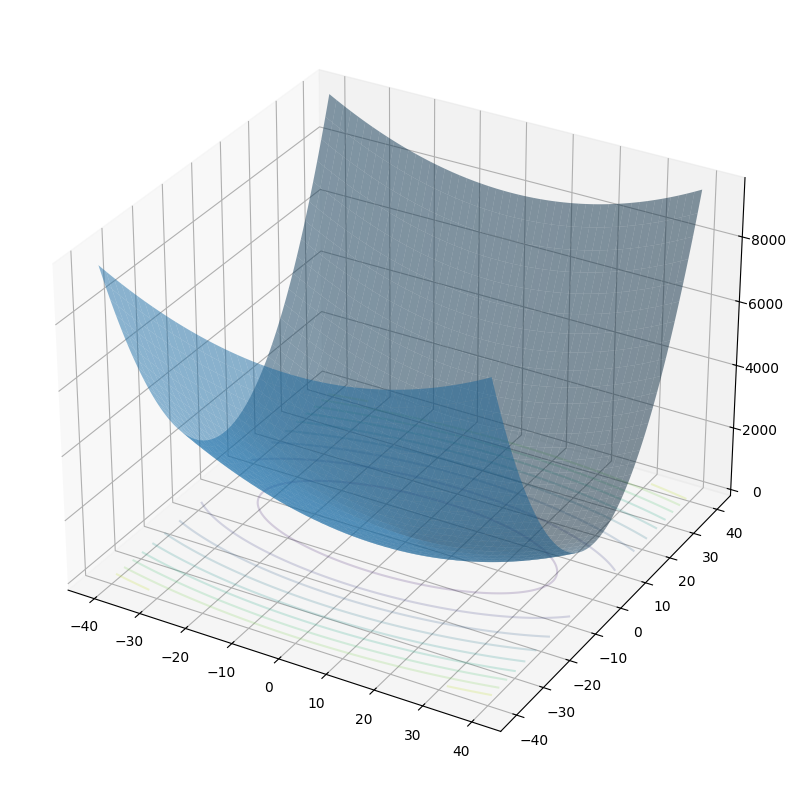

In [104]:
# Generate mesh points
n = 40
a0 = torch.linspace(-n, n, n**2, requires_grad=False)
a1 = torch.linspace(-n, n, n**2, requires_grad=False)
A0, A1 = torch.meshgrid(a0, a1)
A0.requires_grad = True
A1.requires_grad = True

# Evalue curvature
c_val = curve(A0, A1)

# Compute gradients
c_val.sum().backward()

# get gradients for plotting
G0 = A0.grad
G1 = A1.grad

# plotting: values need to be detached for ploting
A0 = A0.detach().numpy()
A1 = A1.detach().numpy()
c_val = c_val.detach().numpy()


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
# plot 3d surface plot
ax.plot_surface(A0, A1, c_val, alpha=0.5)

# iso contours projection on to the c-min plance
c_min = c_val.min()
ax.contour(A0, A1, c_val, offset=c_min, zdir='z', levels=10, alpha=0.2)


In [128]:
import torch
import numpy as np
import plotly.graph_objects as go

# ----- Generate mesh points -----
n = 40
a0 = torch.linspace(-n, n, n)
a1 = torch.linspace(-n, n, n)

A0, A1 = torch.meshgrid(a0, a1, indexing="ij")
A0.requires_grad_(True)
A1.requires_grad_(True)

# ----- Define curvature / loss function -----
def curve(x, y):
    return x**2 + 5*y**2

# ----- Evaluate -----
c_val = curve(A0, A1)

# ----- Gradients -----
c_val.sum().backward()
G0n = A0.grad
G1n = A1.grad

# ----- Convert to numpy -----
A0n = A0.detach().numpy()
A1n = A1.detach().numpy()
Zn  = c_val.detach().numpy()

# ----- Interactive surface -----
surface = go.Surface(
    x=A0n,
    y=A1n,
    z=Zn,
    colorscale="Viridis",
    opacity=0.85,
    contours={
        "z": {
            "show": True,
            "start": Zn.min(),
            "end": Zn.max(),
            "size": (Zn.max() - Zn.min()) / 20,
            "color": "white"
        }
    }
)

# ----- Gradient vectors (subsample to avoid clutter) -----
step = 4  # increase for fewer arrows

cones = go.Cone(
    x=A0n[::step, ::step].flatten(),
    y=A1n[::step, ::step].flatten(),
    z=Zn[::step, ::step].flatten(),
    u=G0n[::step, ::step].flatten(),
    v=G1n[::step, ::step].flatten(),
    w=np.zeros_like(G0n[::step, ::step].flatten()),
    colorscale="Reds",
    sizemode="absolute",
    sizeref=8,
    showscale=False,
    name="Gradient (tangent)"
)


# ----- Figure -----
fig = go.Figure(data=[surface, cones])

fig.update_layout(
    title="Interactive surface with gradients (tangents) and curvature",
    scene=dict(
        xaxis_title="θ₀",
        yaxis_title="θ₁",
        zaxis_title="L(θ₀, θ₁)",
    ),
    width=900,
    height=900
)

fig.show()


In [125]:
import torch
import numpy as np
import plotly.graph_objects as go

# -----------------------------
# Parameters
# -----------------------------
n = 40
alpha_values = [1, 2, 5, 10, 20]   # curvature slider
lr = 0.1
steps = 15
start = torch.tensor([2.5, 1.5])

# -----------------------------
# Grid
# -----------------------------
a0 = torch.linspace(-3, 3, n)
a1 = torch.linspace(-3, 3, n)
A0, A1 = torch.meshgrid(a0, a1, indexing="ij")

# -----------------------------
# Optimization paths
# -----------------------------
def gradient_descent(alpha):
    theta = start.clone().requires_grad_(True)
    path = []
    for _ in range(steps):
        L = theta[0]**2 + alpha * theta[1]**2
        L.backward()
        with torch.no_grad():
            path.append(theta.clone())
            theta -= lr * theta.grad
            theta.grad.zero_()
    return torch.stack(path)

def newton_method(alpha):
    theta = start.clone()
    H = torch.tensor([[2., 0.], [0., 2*alpha]])
    Hinv = torch.inverse(H)
    path = []
    for _ in range(steps):
        grad = torch.tensor([2*theta[0], 2*alpha*theta[1]])
        path.append(theta.clone())
        theta -= Hinv @ grad
    return torch.stack(path)

# -----------------------------
# Figure frames (slider)
# -----------------------------
frames = []

for alpha in alpha_values:
    Z = A0**2 + alpha * A1**2

    # Optimization paths
    gd = gradient_descent(alpha)
    nt = newton_method(alpha)

    # Hessian eigenvectors
    H = torch.tensor([[2., 0.], [0., 2*alpha]])
    eigvals, eigvecs = torch.linalg.eig(H)

    frames.append(go.Frame(
        name=f"α = {alpha}",
        data=[
            # Surface
            go.Surface(
                x=A0.numpy(), y=A1.numpy(), z=Z.numpy(),
                colorscale="Viridis", opacity=0.85,
                colorbar=dict(
                    x=1.05,
                    len=0.75,
                    thickness=18
                )
            ),
            # Gradient descent path
            go.Scatter3d(
                x=gd[:,0], y=gd[:,1],
                z=(gd[:,0]**2 + alpha*gd[:,1]**2),
                mode="lines+markers",
                line=dict(color="red", width=5),
                name="Gradient Descent"
            ),
            # Newton path
            go.Scatter3d(
                x=nt[:,0], y=nt[:,1],
                z=(nt[:,0]**2 + alpha*nt[:,1]**2),
                mode="lines+markers",
                line=dict(color="cyan", width=5),
                name="Newton"
            ),
            # Hessian eigenvectors
            go.Scatter3d(
                x=[0, eigvecs[0,0].real],
                y=[0, eigvecs[1,0].real],
                z=[0, 0],
                mode="lines",
                line=dict(color="white", width=6),
                name="Eigenvector 1"
            ),
            go.Scatter3d(
                x=[0, eigvecs[0,1].real],
                y=[0, eigvecs[1,1].real],
                z=[0, 0],
                mode="lines",
                line=dict(color="yellow", width=6),
                name="Eigenvector 2"
            )
        ]
    ))

# -----------------------------
# Initial figure
# -----------------------------
fig = go.Figure(
    data=frames[0].data,
    frames=frames
)

# -----------------------------
# Slider
# -----------------------------
fig.update_layout(
    title="Tangent, Curvature, Optimization & Hessian Geometry",
    scene=dict(
        xaxis_title="θ₀",
        yaxis_title="θ₁",
        zaxis_title="L(θ₀, θ₁)"
    ),
    sliders=[{
        "steps": [
            {"args": [[f.name], {"frame": {"duration": 0}}], "label": f.name, "method": "animate"}
            for f in frames
        ],
        "currentvalue": {"prefix": "Curvature "}
    }],
    legend=dict(
        x=0.5,
        y=1.02,
        xanchor="center",
        yanchor="bottom",
        orientation="h",
        bgcolor="rgba(255,255,255,0.85)",  # opaque enough to cover colorbar
        bordercolor="black",
        borderwidth=0.1
    ),
    width=950,
    height=900
)

fig.show()


# Drawing gradients

In [129]:
import torch
import numpy as np
import plotly.graph_objects as go

# ----- Generate mesh points -----
n = 40
a0 = torch.linspace(-n, n, n)
a1 = torch.linspace(-n, n, n)

A0, A1 = torch.meshgrid(a0, a1, indexing="ij")
A0.requires_grad_(True)
A1.requires_grad_(True)

# ----- Define curvature / loss function -----
def curve(x, y):
    return x**2 + 5*y**2

# ----- Evaluate -----
c_val = curve(A0, A1)

# ----- Gradients -----
c_val.sum().backward()
G0n = A0.grad
G1n = A1.grad

# ----- Convert to numpy -----
A0n = A0.detach().numpy()
A1n = A1.detach().numpy()
Zn  = c_val.detach().numpy()

# ----- Interactive surface -----
surface = go.Surface(
    x=A0n,
    y=A1n,
    z=Zn,
    colorscale="Viridis",
    opacity=0.85,
    contours={
        "z": {
            "show": True,
            "start": Zn.min(),
            "end": Zn.max(),
            "size": (Zn.max() - Zn.min()) / 20,
            "color": "white"
        }
    }
)

# ----- Gradient vectors (subsample to avoid clutter) -----
step = 4  # increase for fewer arrows

cones = go.Cone(
    x=A0n[::step, ::step].flatten(),
    y=A1n[::step, ::step].flatten(),
    z=Zn[::step, ::step].flatten(),
    u=G0n[::step, ::step].flatten(),
    v=G1n[::step, ::step].flatten(),
    w=np.zeros_like(G0n[::step, ::step].flatten()),
    colorscale="Reds",
    sizemode="absolute",
    sizeref=8,
    showscale=False,
    name="Gradient (tangent)"
)


# ----- Figure -----
fig = go.Figure(data=[surface, cones])

fig.update_layout(
    title="Interactive surface with gradients (tangents) and curvature",
    scene=dict(
        xaxis_title="θ₀",
        yaxis_title="θ₁",
        zaxis_title="L(θ₀, θ₁)",
    ),
    width=900,
    height=900
)

fig.show()


In [136]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget


# ----- Enable interactivity -----
plt.ion()

# ----- Grid -----
n = 40
a0 = torch.linspace(-3, 3, n)
a1 = torch.linspace(-3, 3, n)
A0, A1 = torch.meshgrid(a0, a1)
A0.requires_grad = True
A1.requires_grad = True

# ----- Function -----
Z = A0**2 + 5*A1**2

# ----- Gradients -----
Z.sum().backward()
G0 = 2*A0.detach()
G1 = 10*A1.detach()

# ----- Convert -----
A0n = A0.detach().numpy()
A1n = A1.detach().numpy()
Zn = Z.detach().numpy()

# ----- Plot -----
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")

# Surface
ax.plot_surface(
    A0n, A1n, Zn,
    cmap="viridis",
    alpha=0.8,
    linewidth=0
)

# Gradient arrows (tangent)
step = 4
ax.quiver(
    A0n[::step, ::step],
    A1n[::step, ::step],
    Zn[::step, ::step],
    G0[::step, ::step],
    G1[::step, ::step],
    np.zeros_like(G0[::step, ::step]),
    color="red",
    length=0.4,
    normalize=True
)

ax.set_xlabel("θ₀")
ax.set_ylabel("θ₁")
ax.set_zlabel("L(θ₀,θ₁)")

plt.show()


RuntimeError: 'widget is not a recognised GUI loop or backend name